In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy.stats import norm
from scipy import stats

import xgboost as xgb
from sklearn.model_selection import train_test_split

In [2]:
train = pd.read_csv("../../../mltestdata/03_predict_hourly_wage/Income_training.csv")
test = pd.read_csv("../../../mltestdata/03_predict_hourly_wage/Income_testing.csv")

# Data Exploring

In [3]:
train.head()

,compositeHourlyWages,age,yearsEducation,sex1M0F
0,21.38,58,10,1
1,25.15,42,16,1
2,8.57,31,12,0
3,12.07,43,13,0
4,10.97,46,12,0


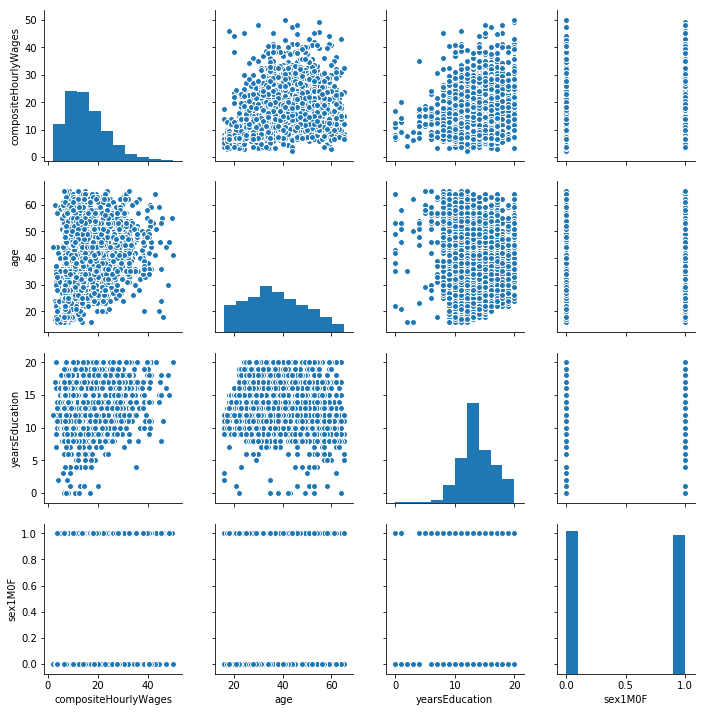

In [4]:
sns.pairplot(train)

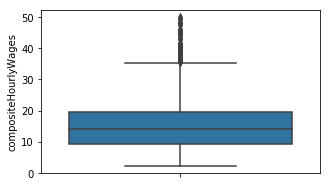

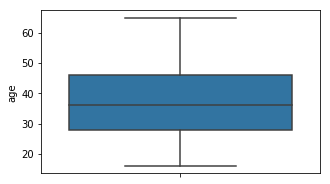

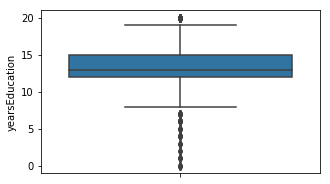

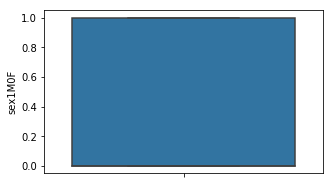

In [5]:
for column in train.columns:
    fig = plt.figure(figsize=(5,3))
    ax = sns.boxplot(y=column, data=train)

# Preprocessiong
* * * *

In [6]:
train.describe()

,compositeHourlyWages,age,yearsEducation,sex1M0F
count,3197.000000,3197.000000,3197.000000,3197.000000
mean,15.495127,36.884579,13.180794,0.491711
std,7.754763,11.996980,3.042127,0.500009
min,2.300000,16.000000,0.000000,0.000000
25%,9.250000,28.000000,12.000000,0.000000
50%,14.210000,36.000000,13.000000,0.000000
75%,19.650000,46.000000,15.000000,1.000000
max,49.920000,65.000000,20.000000,1.000000


In [7]:
ye_outlier_max = (15+1.5*(15-12))
ye_outlier_min = (12-1.5*(15-12))

cw_outlier_max = (19.65+1.5*(19.65-9.25))
cw_outlier_min = (9.25-1.5*(19.65-9.25))

In [8]:
adjustment = 6
adjustment_cw = 7

print("cw/ max: %f, min: %f" % (cw_outlier_max+adjustment_cw,cw_outlier_min-adjustment_cw))
print("ye/ max: %f, min: %f" % (ye_outlier_max+adjustment,ye_outlier_min-adjustment))

#print("cw/ max: %f, min: %f" % (cw_outlier_max,cw_outlier_min))
ye_outlier_max = ye_outlier_max + adjustment
ye_outlier_min = ye_outlier_min - adjustment

cw_outlier_max = cw_outlier_max + adjustment
cw_outlier_min = cw_outlier_min - adjustment

cw/ max: 42.250000, min: -13.350000
ye/ max: 25.500000, min: 1.500000


In [9]:
#Deleting outliers
#train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)
train = train.drop(train[(train['yearsEducation']<ye_outlier_min) | (train['yearsEducation']>ye_outlier_max)].index)
train = train.drop(train[(train['compositeHourlyWages']<cw_outlier_min) | (train['compositeHourlyWages']>cw_outlier_max)].index)

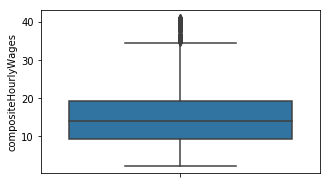

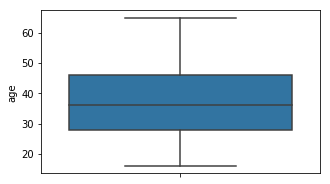

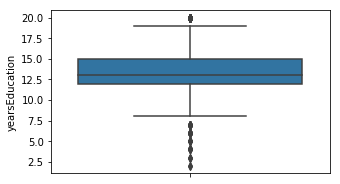

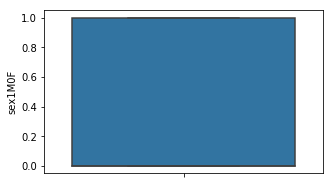

In [10]:
for column in train.columns:
    fig = plt.figure(figsize=(5,3))
    ax = sns.boxplot(y=column, data=train)

* * *

In [11]:
train_target = train.compositeHourlyWages.values

test_ID = test['ID']
test.drop("ID", axis = 1, inplace = True)

train.drop(['compositeHourlyWages'], axis=1, inplace=True)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(train,train_target,test_size=0.2,random_state=0)

# Modeling
* * * * *

## XGBoost

### 1. Validation with local train

In [13]:
# xgboostモデルの作成
#ind_params = {'objective': 'reg:linear'}

#reg = xgb.XGBRegressor(**ind_params)
reg = xgb.XGBRegressor()
reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [14]:
y_train_predict = reg.predict(X_train)
y_pred = reg.predict(X_test)

In [15]:
# The error metric: RMSE
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

print("RMSE from local train: ", rmse(y_test, y_pred))
print("MSE from local train: ", mean_squared_error(y_test, y_pred))
print("R2 from local train: ", r2_score(y_test, y_pred))

RMSE from local train:  5.64666726102
MSE from local train:  31.8848511566
R2 from local train:  0.40259954923


### 2. Validation with GridSearch

In [16]:
from sklearn.model_selection import GridSearchCV

In [17]:
# XGBoost params
xgb_params = {
    'objective' : ['reg:gamma','reg:linear'],
    'learning_rate' : [0.1,0.125,0.15],
    'n_estimators' : [45,50,55],
    'max_depth' : [2,4,6],
    'subsample' : [0.79,0.8,0.81],
    'colsample_bytree' : [0.9,1.0],
    'min_child_weight' : [13, 14, 15]
}

In [18]:
#scoring_func = make_scorer(mean_squared_error)

#grid = GridSearchCV(reg,xgb_params,scoring=scoring_func,cv=5,n_jobs=-1)
grid = GridSearchCV(reg,xgb_params,scoring='neg_mean_squared_error',cv=5,n_jobs=-1)

grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'objective': ['reg:gamma', 'reg:linear'], 'learning_rate': [0.1, 0.125, 0.15], 'n_estimators': [45, 50, 55], 'max_depth': [2, 4, 6], 'subsample': [0.79, 0.8, 0.81], 'colsample_bytree': [0.9, 1.0], 'min_child_weight': [13, 14, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [19]:
# Best Params and Score
print("Best params: ", grid.best_params_)
print("Best Estimator: ", grid.best_estimator_)

print("MSE: ", grid.best_score_)

# best_score_ : Mean cross-validated score of the best_estimator

Best params:  {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 2, 'min_child_weight': 14, 'n_estimators': 55, 'objective': 'reg:linear', 'subsample': 0.81}
Best Estimator:  XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=14, missing=None, n_estimators=55,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.81)
MSE:  -35.3778411479


In [25]:
# The result of combination
#index = 1
#for params, mean_score, scores in grid.grid_scores_:
#    print("%d) %0.3f (+/-%0.03f) " % (index, mean_score, scores.std() / 2))
#    print("Params: %r" % params)
#    print("_"*30)
#    index = index + 1

In [21]:
# 改めて最適パラメータで学習
gdm = xgb.XGBRegressor(**grid.best_params_)
#gdm = xgb.XGBRegressor(**xgb_params)
gdm.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=14, missing=None, n_estimators=55,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.81)

In [22]:
y_pred_gs = gdm.predict(X_test)

In [23]:
# The error metric: RMSE
print("RMSE from local train: ", rmse(y_test, y_pred_gs))
print("MSE from local train: ", mean_squared_error(y_test, y_pred_gs))
print("R2 from local train: ", r2_score(y_test, y_pred_gs))

RMSE from local train:  5.56330578469
MSE from local train:  30.9503712539
R2 from local train:  0.420108137003


- adjustment = 7
 - RMSE from local train:  6.1603520332
- adjustment = 6
 - RMSE from local train:  6.12037443173
- adjustment = 4 
 - RMSE from local train:  6.1909839841
- adjustment = 3
 - RMSE from local train:  6.2428962048

- adjustment = 6 & adjustment_cw = 6
 - RMSE from local train:  5.56330578469
  


In [24]:
predictions_gdm = gdm.predict(test)

# Submission

In [27]:
sub = pd.DataFrame()
sub['ID'] = test_ID
sub['compositeHourlyWages'] = predictions_gdm
sub.to_csv('rs_hourly_submission_30Dec17_04_rs_predict_hourly_wage_v07_xgb-outlier.csv',index=False)

* * * *

- compositeHourlyWage & yearsofEducation
 - 6.42361

- yearsofEducation
 - 6.31811